## Human Activity Recognition

This notebook contains the code for processing the MotionSense dataset using AI and Machine Learning.

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

## 2. Dataset Loading and Sensor Column Setup

This code facilitates data loading. It reads CSV files using get_ds_infos() and set_data_types todefine the sensor columns.

In [2]:
# Step 1: Load Subject Information
def get_ds_infos():
    return pd.read_csv("./data/data_subjects_info.csv")

# Step 2: Define sensor columns
def set_data_types(data_types=["userAcceleration"]):
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list


## 3. Dataset Construction from Raw Files
create_time_series() combines sensor data (attitude, userAcceleration) and creates a time series.

In [3]:
# Step 3: Create Time-Series from raw data
def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+1)) # "1" --> [act] we do not need the other labels
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = './data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

## 4. Activities
The following code defines activities and trials 

In [12]:
# Step 5:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:6]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 7)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0


# Data Pre-processing

## 6. Data Windowing

For each window (shape: `[window_size, n_axes]`), we compute:
- Time-domain: mean & standard deviation on each axis  
- Frequency-domain: spectral energy via FFT on each axis  
- Then normalize all features to zero mean & unit variance.

In [13]:
# Windowing function
def windows(dataset, window_size=100, stride=50):
    windows_list = []
    labels_list = []
    for act_id, group in dataset.groupby('act'):
        data = group.drop('act', axis=1).values
        for start in range(0, len(data) - window_size + 1, stride):
            end = start + window_size
            windows_list.append(data[start:end])
            labels_list.append(act_id)
    return np.stack(windows_list).astype(np.float32), np.array(labels_list).astype(np.int64)


Extract windows

In [14]:
# Extract windows
X_windows, y_windows = windows(dataset, window_size=100, stride=50)

import numpy as np
from sklearn.preprocessing import StandardScaler

def extract_features_from_window(window: np.ndarray):
    """
    window: np.ndarray of shape (window_size, n_axes)
    returns: 1D feature vector [μ_axis1, σ_axis1, E_axis1, …]
    """
    feats = []
    # Time-domain
    feats.extend(window.mean(axis=0).tolist())   # mean per axis
    feats.extend(window.std(axis=0).tolist())    # std per axis

    # Frequency-domain
    fft_vals = np.fft.rfft(window, axis=0)       # real FFT per axis
    energy   = np.sum(np.abs(fft_vals)**2, axis=0)
    feats.extend(energy.tolist())                # spectral energy per axis

    return np.array(feats, dtype=np.float32)

# Build feature matrix shape (n_samples, n_features)
X_features = np.vstack([extract_features_from_window(w) for w in X_windows])

# Normalize features: zero mean, unit variance
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

## 5. Train/Validation/Test Split

In [15]:
# Utility to split train/val/test
def train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=None):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X_features, y_windows, test_size=0.2, val_size=0.1, random_state=42
)


# Models
Class definitions for the Random Forest, LSTM and the pre train ---- Model.

# Training and Evaluation

Validation Accuracy: 0.9699115044247788

Random Forest Test Classification Report:

              precision    recall  f1-score   support

         dws       0.95      0.87      0.91       527
         ups       0.91      0.92      0.92       629
         wlk       0.95      0.97      0.96      1377
         jog       0.99      0.98      0.98       537
         std       0.99      1.00      1.00      1225
         sit       1.00      1.00      1.00      1355

    accuracy                           0.97      5650
   macro avg       0.96      0.96      0.96      5650
weighted avg       0.97      0.97      0.97      5650

Test Accuracy: 0.9690265486725663
Test Precision: 0.9690759651700589
Test Recall: 0.9690265486725663
Test F1 Score: 0.9688405000778721


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

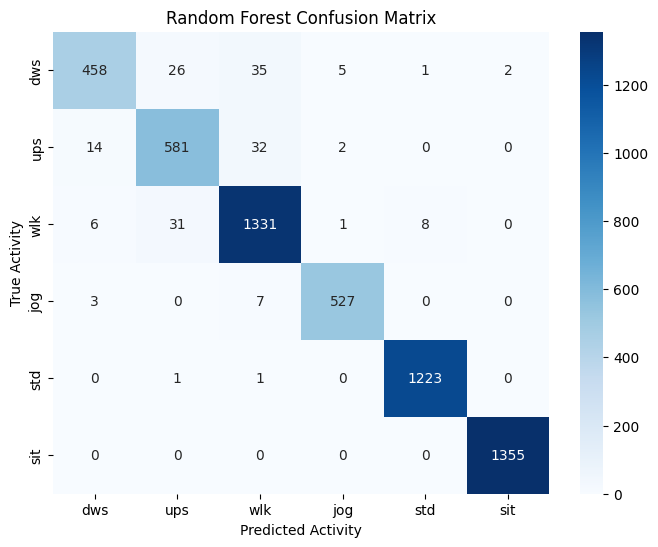

In [ ]:
# 7.1 Split into train/val/test
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X_features, y_windows, test_size=0.2, val_size=0.1, random_state=42
)

# 7.2 Instantiate and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

val_preds = rf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))

# 7.4 Test evaluation
y_pred = rf.predict(X_test)
print("\nRandom Forest Test Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=act_labels))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Test Recall:", recall_score(y_test, y_pred, average='weighted'))
print("Test F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# 7.5 Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=act_labels,
    yticklabels=act_labels
)
plt.xlabel('Predicted Activity')
plt.ylabel('True Activity')
plt.title('Random Forest Confusion Matrix')

In [ ]:

print("=== Random Forest Parameters ===")
print(rf)           # shows n_estimators, max_depth, etc.


if hasattr(rf, 'feature_importances_'):
    print("=== Feature Importances ===")
    for i, imp in enumerate(rf.feature_importances_):
        print(f"Feature {i}: {imp:.4f}")

=== Random Forest Parameters ===
RandomForestClassifier(random_state=42)
=== Feature Importances ===
Feature 0: 0.0161
Feature 1: 0.0848
Feature 2: 0.0130
Feature 3: 0.0170
Feature 4: 0.0122
Feature 5: 0.0464
Feature 6: 0.0527
Feature 7: 0.0512
Feature 8: 0.0537
Feature 9: 0.0720
Feature 10: 0.1495
Feature 11: 0.0779
Feature 12: 0.0249
Feature 13: 0.1229
Feature 14: 0.0229
Feature 15: 0.0500
Feature 16: 0.0811
Feature 17: 0.0518
